# Анализ оттока клиентов сети фитнес-центров

**Описание и цель проекта:**

Распространённой проблемой фитнес-клубов и других сервисов является отток клиентов. Наша задача провести анализ и подготовить план действий по удержанию клиентов. 

В ходе исследования будут даны ответы на следующие вопросы:
 - спрогнозируем вероятность оттока для каждого клиента;
 - сформируем типичные портреты клиентов: выделим несколько наиболее ярких групп и охарактеризуем их основные свойства;
 - спрогнозируем основные признаки, наиболее сильно влияющие на отток;
 - дадим рекомендации по повышению качества работы с клиентами
 
В нашем распоряжении данные, которые содержат информацию на месяц до оттока и факт оттока на определённый месяц.


**Этапы исследования:**

1) Обзор данных\
2) Исследовательский анализ данных (EDA)\
3) Построение модели прогнозирования оттока клиентов\
4) Кластеризация клиентов\
5) Выводы и рекомендации

## Обзор данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Сохраним данные из файла в переменной df
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# Получим общую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В датасете 4000 строк, пропуски отсутствуют, тип данных корректный. Наименования столбцов стилистически некорректны - переведем названия в нижний регистр.

In [4]:
df.columns = df.columns.str.lower()

In [5]:
# Проверим данные на явные дубликаты
df.duplicated().sum()

0

**Вывод:**
- пропусков в данных нет
- тип данных и наименование столбцов корректны
- явных дубликатов нет

## Исследовательский анализ данных (EDA)

### Общая информация о данных, оценка средних значений и стандартного отклонения

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


1) `gender`: распределение по полу примерно 50% на 50%, стандартное отклонение - 0.5

2) `near_location`: примерно 85% проживают или работают в районе, где находится фитнес-центр, стандартное отклонение - 0.36

3) `partner`: практически половина клиентов (49%) - это сотрудники компании-партнёра клуба, стандартное отклонение - 0.5

4) `promo_friends`: 30% клиентов пришли в клуб по рекомендации друзей, стандартное отклонение - 0.46

5) `phone`: у 90% клиентов заполнен контактный телефон, стандартное отклонение - 0.3

6) `contract_period`: при оценке длительности текущего действующего абонемента более приоритетно смотреть на показатель медианы, в нашем случае он равняется 1, значит больше всего абонементов с периодом в 1 месяц.

7) `group_visits`: групповые занятия посещают около 41% клиентов, стандартное отклонение - 0.49

8) `age`: средний и медианный возраст клиентов одинаковый - 29 лет, минимальный возраст - 18 лет, максимальный - 41 год

9) `avg_additional_charges_total`: суммарная выручка от других услуг фитнес-центра в среднем составляет 147 у.е., медианное значение довольно близко к среднему - 136 у.е. Стандартное отклонение значительное - 96.3. Максимальный размер трат составил - 552 у.е., минимальный - 0,148

10) `month_to_end_contract`: средний срок до окончания текущего действующего абонемента - 4 месяца, медианное значение - 1 месяц, стандартное отклонение -  4,2

11) `lifetime`: среднее и медианное значение времени с момента первого обращения в фитнес-центр практически одинаковое - 3 месяца, это свидетельствует о том, что в фитнес-центре много новых клиентов. Максимальное значение - 31 месяц

12) `avg_class_frequency_total`: средняя частота посещений в неделю за все время с начала действия абонемента - 1-2 раза. Максимальное значение - 6 дней в неделю. Стандартное отклонение - 0.9

13) `avg_class_frequency_current_month`: средняя частота посещений в неделю за предыдущий месяц - 1-2 раза. Максимальное значение - 6 дней в неделю. Стандартное отклонение - 1.05

14) `churn`: отток в текущем месяце составил 27%, стандартное отклонение - 0.44.


### Cредние значения признаков тех, кто ушел в отток и тех, кто остался

In [7]:
df.groupby('churn').agg('mean').T.round(3)

churn,0,1
gender,0.510,0.511
near_location,0.873,0.768
partner,0.534,0.355
promo_friends,0.354,0.184
phone,0.904,0.903
contract_period,5.747,1.729
group_visits,0.464,0.269
age,29.977,26.990
avg_additional_charges_total,158.446,115.083
month_to_end_contract,5.283,1.663


Значительные различия между группами наблюдаются по следующим признакам:

1) среди группы оттока меньшее количество клиентов пришли в клуб по партнерской программе или по рекомендации друзей\
2) в группе оттока клиенты, как правило, берут абонемент на 1 месяц, показатели в группе оставшихся противоположные - средняя длительность абонемента практически полгода\
3) в группе оттока клиенты реже посещают групповые занятия - примерно 27%\
4) время с момента первого посещения значительно отличается: в группе оттока этот показатель равен 1-2 месяца, в группе оставшихся - 5 месяцев\
5) группа оттока реже посещает клуб - примерно 1 раз в неделю, средняя частота посещения у группы оставшихся - 2 раза в неделю.

### Графическое отображение признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

Разделим переменные на 2 группы: числовые и категориальные. Для каждой группы построим графики.

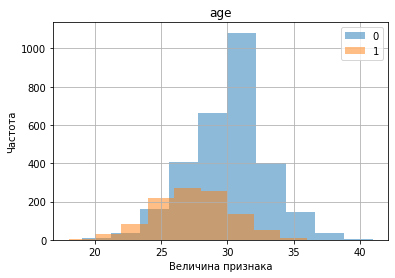

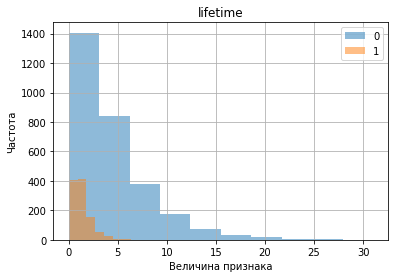

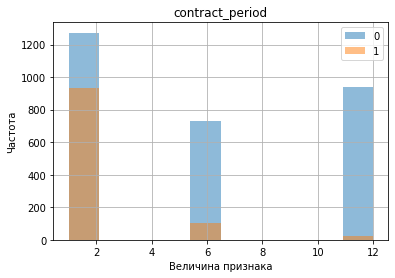

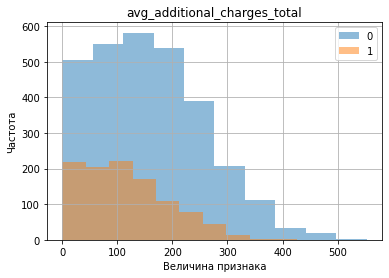

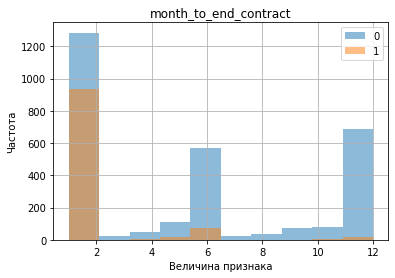

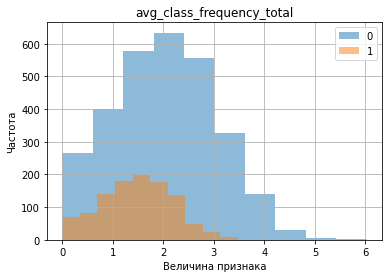

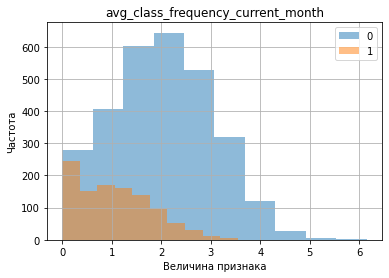

In [8]:
# Выделим числовые переменные
q_var = ['age', 'lifetime', 'contract_period', 'avg_additional_charges_total', 'month_to_end_contract', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

for i in q_var:
    df.groupby('churn')[i].hist(alpha=0.5)
    plt.legend(df['churn'].unique())
    plt.xlabel("Величина признака")
    plt.ylabel("Частота")
    plt.title(i)
    plt.show()

На графиках видно, что чаще всего уходят клиенты в возрасте от 25 до 30 лет, у которых абонемент оформлен на 1 месяц и время с момента первого обращения в фитнес-центр составляет 1-2 месяца.

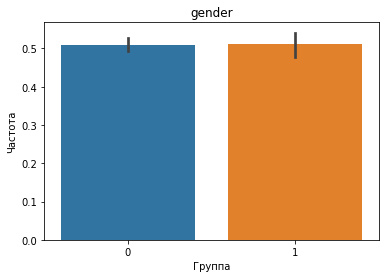

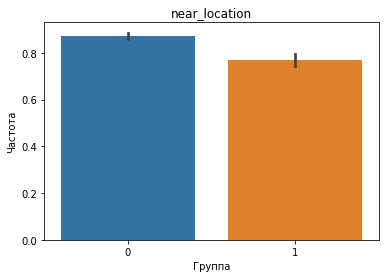

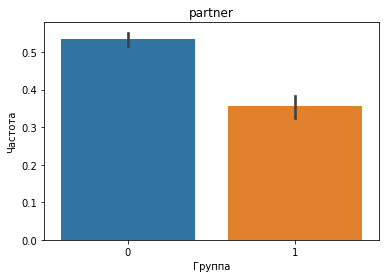

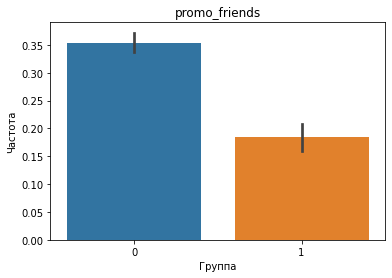

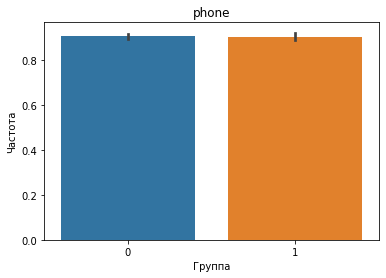

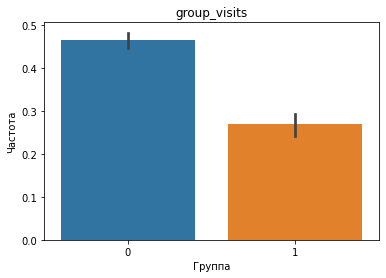

In [9]:
# Выделим категориальные переменные
с_var = ['gender','near_location', 'partner', 'promo_friends','phone', 'group_visits']

for i in с_var:
    sns.barplot(data=df, x='churn', y=i)
    plt.xlabel("Группа")
    plt.ylabel("Частота")
    plt.title(i)
    plt.show()

На графиках видно, что чаще клиенты остаются, если пришли по программе партнеров или рекомендации друзей, посещают групповые занятия и живут недалеко от фитнес-центра.

### Матрица корреляций

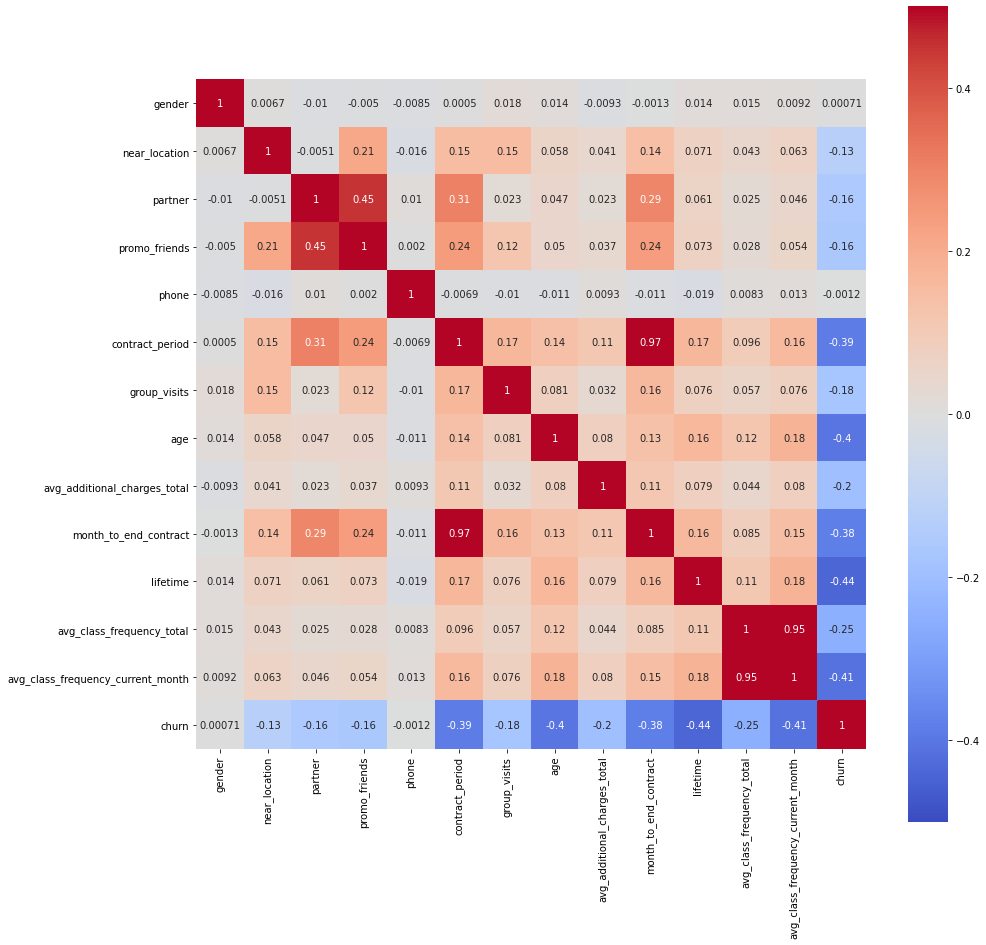

In [10]:
cm = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot = True, square=True, vmin=-0.5, vmax=0.5, cmap= 'coolwarm')
plt.show()

1) Сильная прямая связь присутствует между следующими признаками:
- `avg_class_frequency_total` и `avg_class_frequency_current_month`, что свидетельствует о стабильном поведение клиентов (посещение или прогул)
- `month_to_end_contract` и `contract_period`, данная зависимость тоже логически объяснима: чем больше срок действия абонемента, тем больше срок до его окончания

2) Средняя прямая связь наблюдается между признаком `promo_friends` и `partner`, вероятно, клиенты клуба часто рекомендуют фитнес-центр своим коллегам, особенно, если он находится рядом с работой.

3) Обратная связь чуть ниже средней степени наблюдается у следующих признаков:
- `churn`и `lifetime`
- `churn`и `avg_class_frequency_current_month`
- `churn`и `age`
- `churn`и `contract_period`
- `churn`и `month_to_end_contract`

**Вывод:**

На данном этапе мы проанализировали значения признаков у двух групп клиентов: группе оттока и группе оставшихся.

- среди группы оттока меньшее количество клиентов пришли в клуб по партнерской программе или по рекомендации друзей, при этом между этими признаками наблюдается прямая корреляционная зависимость средней степени

- в группе оттока клиенты, как правило, берут абонемент на 1 месяц, показатели в группе оставшихся противоположные - средняя длительность абонемента практически полгода

- в группе оттока клиенты реже посещают групповые занятия - примерно 27%

- группа оттока реже посещает клуб - примерно 1 раз в неделю, средняя частота посещения у группы оставшихся - 2 раза в неделю.


## Модель прогнозирования оттока клиентов

### Обучающая и валидационная выборка

In [11]:
# Разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# Разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Скалируем данные
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучение модели на train-выборке

#### Логистическая регрессия

In [12]:
model = LogisticRegression(random_state = 0, solver='liblinear')
model.fit(X_train_st, y_train)

predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84


#### Cлучайный лес

In [13]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced') 
rf_model.fit(X_train_st, y_train)

rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]


print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.91
Precision: 0.85
Recall: 0.78
F1: 0.82


**Вывод:**
в данном случае показатели модели логистической регрессии лучше, чем у модели "случайный лес".

## Кластеризация клиентов

### Стандартизация данных

In [14]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Матрица расстояний

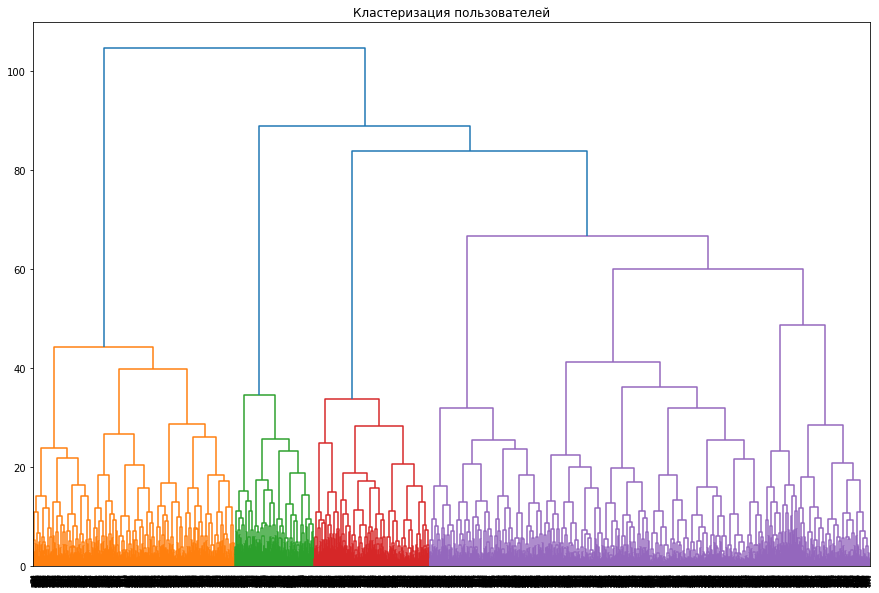

In [15]:
linked = linkage(X_sc, method='ward')
plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей')
plt.show()

На основании полученного графика можно выделить 4-5 кластеров.

### Модель кластеризации

In [16]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state = 0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc) 
# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels

### Cредние значения признаков для кластеров

In [17]:
df.groupby('cluster').mean().T.round(3)

cluster,0,1,2,3,4
gender,0.503,0.522,0.495,0.486,0.560
near_location,0.959,0.862,0.000,1.000,0.976
partner,0.783,0.470,0.463,0.350,0.357
promo_friends,0.574,0.306,0.079,0.240,0.230
phone,1.000,0.000,1.000,1.000,0.999
contract_period,10.889,4.787,2.352,1.948,2.669
group_visits,0.543,0.426,0.216,0.342,0.474
age,29.982,29.301,28.477,28.168,30.125
avg_additional_charges_total,160.761,143.958,135.458,131.622,161.658
month_to_end_contract,9.954,4.475,2.198,1.857,2.459


В `кластере 0` собраны клиенты, которые живут или работают рядом с фитнес-центром. Среди них практически 80% являются сотрудниками компаний-партнеров, и более 50% пришли по рекомендации друзей. Как правило, они покупают абонементы на длительный срок, ходят в клуб в среднем уже почти 5 месяцев, примерно 2 раза в неделю. У этого кластера наименьший % оттока.

`Кластер 1` по своим характеристикам достаточно похож на кластер 0, но в нем меньше клиентов, кто пришёл по рекомендации друзей или являются сотрудником компаний-партнеров. В этом кластере клиенты не предоставили информацию по номеру телефона, средний срок абонемента - 5 месяцев, % оттока - 27%.

В `кластере 2` собраны клиенты, которые пришли не по акции друзей, живут далеко от клуба и почти не ходят на групповые занятия. Отток таких клиентов достаточно большой - 40%.

В `кластер 3` попали клиенты, которые живут или работают рядом с фитнес-центром, большинство из них пришли не по акции «приведи друга» и не являются сотрудниками компаний-партнеров. У данной группы абонементы с минимальным сроком - 1-2 месяца и большой % оттока - 51%.

`Кластер 4` включает в себя клиентов, которые в основном живут или работают рядом с фитнес-центром, пришли не по акции «приведи друга» и не являются сотрудниками компаний-партнеров. Средний срок их абонементов - 2-3 месяца, в клуб они ходят давно и стабильно, примерно 2-3 раза в неделю, % оттока низкий - 7%.


### Распределение признаков по кластерам

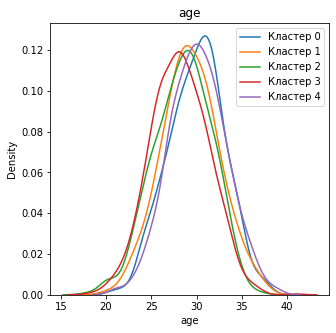

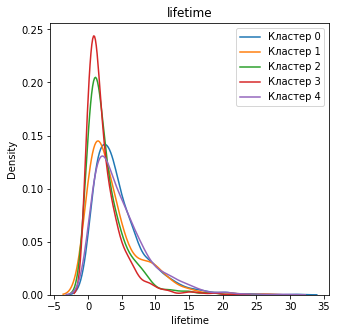

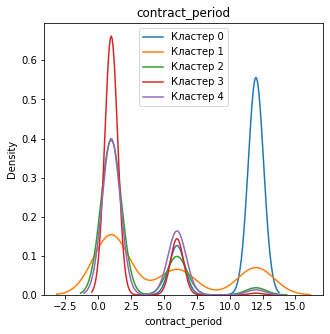

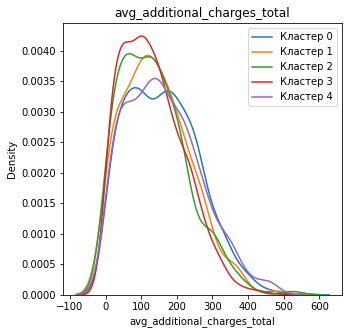

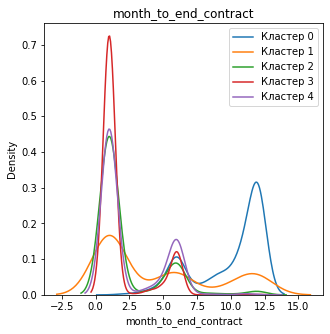

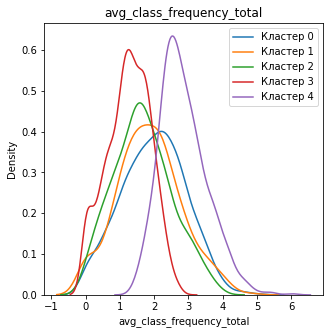

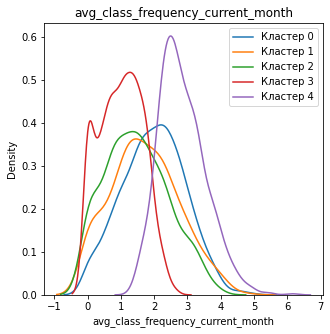

In [18]:
for i in q_var:
    plt.figure(figsize=(5, 5))
    sns.kdeplot(df.query('cluster==0')[i], label = 'Кластер 0')
    sns.kdeplot(df.query('cluster==1')[i], label = 'Кластер 1')
    sns.kdeplot(df.query('cluster==2')[i], label = 'Кластер 2')
    sns.kdeplot(df.query('cluster==3')[i], label = 'Кластер 3')
    sns.kdeplot(df.query('cluster==4')[i], label = 'Кластер 4')
    
    plt.title(i)   
    plt.legend()
    plt.show()

Наибольшее смещение влево (ближе к 0) наблюдается у кластера 3 и 2 - это наиболее уязвимые группы с большим % оттока.

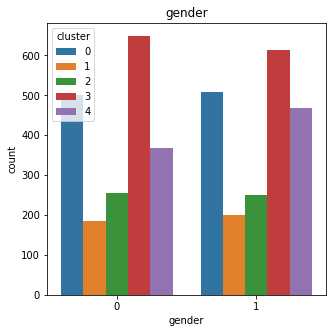

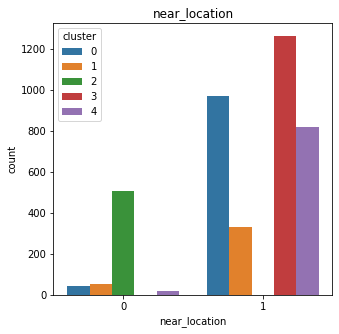

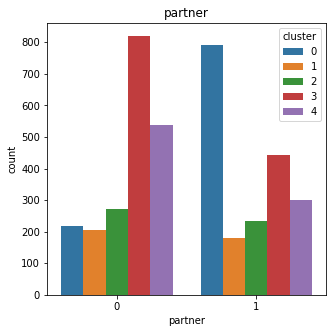

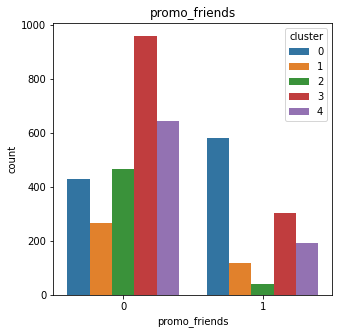

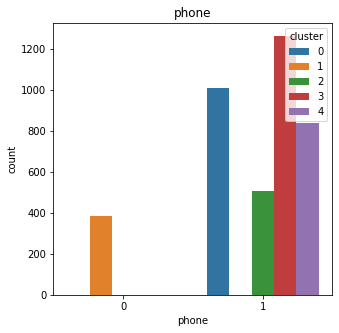

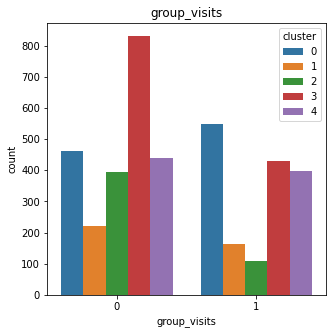

In [19]:
for i in с_var:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[i], hue='cluster', data=df)
    plt.title(i)
    plt.show()

На графике больше всего выделяется 3-й кластер. Клиенты из этого кластера в основном живут/работают рядом с фитнес-клубом, но при этом они пришли не по рекомендации друзей и не по партнерской программе, на групповые занятия, как правило, не ходят.

### Доля оттока по кластерам

In [20]:
df.groupby('cluster').agg({'churn':'mean'}).sort_values(by='churn', ascending = False).round(3)

,churn
cluster,
3,0.514
2,0.444
1,0.268
4,0.068
0,0.028


Наиболее склоны к оттоку кластеры 3 и 2 (% оттока - 40-50%), к надежным относятся 0 и 4 кластер (% оттока - 3-7%)

**Вывод:** 

На данном этапе мы выдели 5 кластеров клиентов и оценили показатели в каждом из них. 

К наиболее уязвимым кластерам, с большим % оттока можно отнести кластеры 3 и 2, в большинстве своем клиенты из этих кластеров не являются сотрудниками компаний-партнёров, пришли в зал не по рекомендации друзей, редко посещают групповые занятия, срок их абонемента - 1-2 месяца.

К надежным кластерам относится 0 и 4 кластер. Из общих характеристик можно выделить то, что эти люди живут/работают рядом с фитнес-центром и достаточно долго (около 5 месяцев) посещают зал.


## Вывод и рекомендации

Целью нашего исследования было выявление признаков оттока клиентов у сети фитнес-клубов «Культурист-датасаентист».

На первом этапе мы проверили корректность данных: убедились, что в данных отсутствуют пропуски и дубликаты, тип данных и наименования столбцов корректны.

На этапе EDA мы выяснили, что:
- среди группы оттока меньшее количество клиентов пришли в клуб по партнерской программе или по рекомендации друзей, при этом между этими признаками наблюдается прямая корреляционная зависимость средней степени
- в группе оттока клиенты, как правило, берут абонемент на 1 месяц, показатели в группе оставшихся противоположные - средняя длительность абонемента практически полгода
- в группе оттока клиенты реже посещают групповые занятия - примерно 27%
- группа оттока реже посещает клуб - примерно 1 раз в неделю, средняя частота посещения у группы оставшихся - 2 раза в неделю.

Далее мы построили модель прогнозирования оттока клиентов, среди методов в данном случае лучше показал себя метод логистической регрессии.

На заключительном этапе мы провели кластеризацию клиентов. Всего было выделено 5 кластеров, которые можно разделить на 2 группы по показателям оттока:
- **Надежные кластеры (0 и 4)**: клиенты в этих кластерах живут/работают рядом с фитнес-центром и достаточно долго (около 5 месяцев) посещают зал.

- **Уязвимые кластеры (3 и 2)**: в большинстве своем клиенты из этих кластеров не являются сотрудниками компаний-партнёров, пришли в зал не по рекомендации друзей, редко посещают групповые занятия, срок их абонемента - 1-2 месяца

**Рекомендации:**
1) стоит сконцентрировать внимания на клиентах из уязвимых кластеров и попытаться увеличить их лояльность

2) так как клиенты из группы оттока в основном не являются сотрудниками компаний-партнёров и пришли в зал не по рекомендации друзей, возможно, стоит уделить внимание их адаптации в клубе через продвижение групповых занятий или индивидуальных занятий с тренером

3) запустить акции на абонементы более длительного срока и организовать мероприятия, направленные на увеличение количества посещений.
